In [70]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split


In [1]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

# Function to load and preprocess images from a directory
def load_images_from_folder(base_path, image_size=(150, 150)):
    images = []
    labels = []
    
    # Get a sorted list of folder names and create a label map
    class_labels = sorted(os.listdir(base_path))
    label_map = {label_name: idx for idx, label_name in enumerate(class_labels)}
    
    for label_name in class_labels:
        label_path = os.path.join(base_path, label_name)
        
        # Ensure the folder contains images and is not empty
        if not os.path.isdir(label_path):
            continue
            
        # Loop through each image in the folder
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read image as grayscale
            
            if image is not None:
                # Resize the image
                image = cv2.resize(image, image_size)
                image = image.astype('float32') / 255.0  # Normalize to range [0, 1]
                images.append(image)
                labels.append(label_map[label_name])  # Use mapped label

    return np.array(images), np.array(labels), label_map

# Load images and labels from dataset
base_path = 'data'  # Replace with the path to your dataset
images, labels, label_map = load_images_from_folder(base_path)


2024-11-22 15:43:19.517842: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 15:43:19.697606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 15:43:19.783610: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 15:43:19.809196: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 15:43:19.934907: I tensorflow/core/platform/cpu_feature_guar

In [2]:
labels

array([ 0,  0,  0, ..., 11, 11, 11])

In [3]:
#suffling
images, labels = shuffle(images, labels, random_state=42)

In [4]:
labels

array([0, 3, 4, ..., 7, 9, 2])

In [5]:

# Define the split sizes
train_size = int(0.7 * images.shape[0])  # 70% for training
val_size = int(0.15 * images.shape[0])   # 15% for validation
test_size = images.shape[0] - train_size - val_size  # Remaining for testing

#one-hot encoding labels
num_classes = len(label_map)
labels = to_categorical(labels, num_classes = num_classes)

# Split the dataset into training, validation, and testing sets
X_train, X_val, X_test = images[:train_size], images[train_size:train_size + val_size], images[train_size + val_size:]
y_train, y_val, y_test = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]
"""
# One-hot encode the labels
num_classes = len(label_map)  # Number of unique classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)
"""
# Output the shapes of the datasets
print(f'Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}')
print(f'One-hot encoded labels shapes: y_train: {y_train.shape}, y_val: {y_val.shape}, y_test: {y_test.shape}')


Training set: (3465, 150, 150, 3), Validation set: (742, 150, 150, 3), Test set: (744, 150, 150, 3)
One-hot encoded labels shapes: y_train: (3465, 12), y_val: (742, 12), y_test: (744, 12)


In [6]:
# Convert back to class vector
class_labels = np.argmax(y_train, axis=1)

# Find unique class labels
unique_values = np.unique(class_labels)

print("Unique class labels:", unique_values)


Unique class labels: [ 0  1  2  3  4  5  6  7  8  9 10 11]


In [7]:
label_map

{'Body_tissue_or_organ_BT': 0,
 'gauze': 1,
 'glass_equipment_packaging_551_GE': 2,
 'gloves': 3,
 'mask': 4,
 'metal_equipment_packaging_ME': 5,
 'organic_wastes_OW': 6,
 'paper_equipment_packaging__PE': 7,
 'plastic_equipment_packaging_PP': 8,
 'syringe': 9,
 'syringe_needles_SN': 10,
 'tweezers': 11}

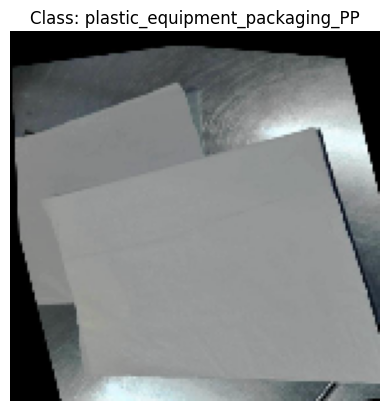

In [8]:
import matplotlib.pyplot as plt
import cv2

# Index of the image to display
index = 80

# Get the image and label
img = X_train[index]
class_index = np.argmax(y_train[index])  # Get the class index from one-hot encoding

# Reverse the label map to map indices to class names
reverse_label_map = {v: k for k, v in label_map.items()}

# Get the class name
class_name = reverse_label_map[class_index]

# Resize and display the image
#img = cv2.resize(img, (100, 100))
plt.imshow(img)
plt.title(f"Class: {class_name}")
plt.axis('off')
plt.show()


In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
#batch_size=10
#setting Training Hyperparameters
batch_size= 100
epochs=5
data_augmentation=True
# Update your checkpoint to use 'val_accuracy'
checkpoint = ModelCheckpoint("medicalwaste.keras", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')

# Update early stopping to monitor 'val_accuracy' with mode='max'
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='max')

# Ensure your steps_per_epoch and validation_steps are set appropriately
steps_per_epoch = len(images) // batch_size  # Adjust based on your data
validation_steps = len(X_test) // batch_size   # Adjust based on your data

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

# Initialize the CNN model
model = Sequential()

# First block of Conv2D + MaxPooling2D layers
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(150,150,3)))  # 32 filters
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Second block of Conv2D + MaxPooling2D layers
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))  # 64 filters
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Third block of Conv2D + MaxPooling2D layers
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))  # 128 filters
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten the feature map into a 1D vector
model.add(Flatten())

# Fully connected layer
model.add(Dense(512, activation="relu"))  # Reduced number of units to prevent overfitting
model.add(Dropout(0.5))  # Dropout for regularization

# Output layer for 12 classes
model.add(Dense(12, activation="softmax"))  # 12 classes, softmax for multi-class classification

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,334,476 (81.38 MB)

 Trainable params: 21,334,028 (81.38 MB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
from keras.optimizers import Adam
from tensorflow.keras import losses

opt = Adam(learning_rate=0.0001)

model.compile(optimizer = opt,loss=losses.categorical_crossentropy,metrics=['accuracy'])
# Now you can fit your model
history = model.fit(
    x=X_train,          # Training inputs
    y=y_train,                          # Training targets
    validation_data=(X_val, y_val),  # Validation data
    steps_per_epoch=steps_per_epoch,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[checkpoint, early]
)

# Evaluate your model on the test data

Epoch 1/5
35/49 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4479 - loss: 2.3699

2024-11-22 16:12:49.561566: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 1: val_accuracy did not improve from 0.14690
49/49 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4787 - loss: 2.1854 - val_accuracy: 0.0836 - val_loss: 3.7200
Epoch 2/5
35/49 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7569 - loss: 0.7786
Epoch 2: val_accuracy did not improve from 0.14690
49/49 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7630 - loss: 0.7559 - val_accuracy: 0.0836 - val_loss: 7.5148
Epoch 3/5
35/49 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8244 - loss: 0.4748
Epoch 3: val_accuracy did not improve from 0.14690
49/49 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.8268 - loss: 0.4729 - val_accuracy: 0.0836 - val_loss: 11.3646
Epoch 4/5
35/49 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.8704 - loss: 0.3824
Epoch 4: val_accuracy did not improve from 0.14690
49/49 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.8682 - loss: 0.3836 - val_accuracy: 0.0836 - val_loss: 13.6397
Epoch 5/5
35/49 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8769 - loss: 0.3813
E

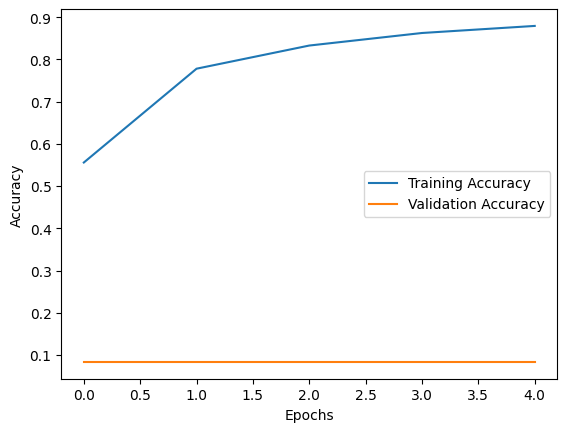

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Use 'val_accuracy' here
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


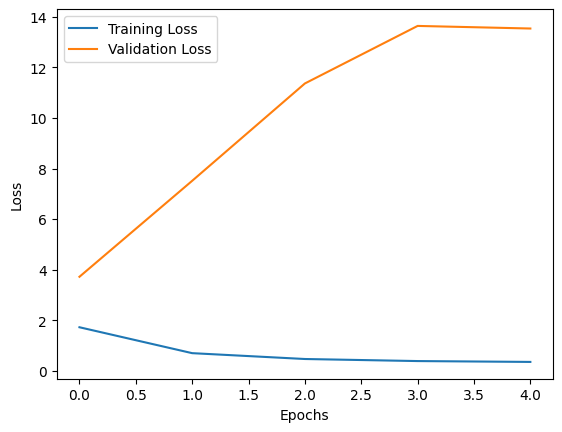

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')  # Use 'val_loss' here
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()